In [1]:
import random 
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.stats import gaussian_kde
from scipy.ndimage import gaussian_filter
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

In [2]:
class mapDependenciesGenerator:
    def __init__(self, numberPoints, maxDependencies):
        self.numberPoints = numberPoints
        self.maxDependencies = maxDependencies
        self.dependencies = list()
    
    def getDependencies(self):
        return self.dependencies 

    def generateDependencies(self):
        self.dependencies.append({
            'id': 0,
            'dependencies': [],
            'directDependencies': [],
        })

        for i in range(1, self.numberPoints):
            possibleDependenciesForPoint = self.dependencies
            numberOfPossibilities = len(possibleDependenciesForPoint)
            numberDependenciesForPoint = random.randint(1, min(numberOfPossibilities, 3))

            point = {
                'id': i,
                'dependencies': [],
                'directDependencies': []
            }

            for ii in range(0, numberDependenciesForPoint):
                if len(possibleDependenciesForPoint) == 0:
                    pass 
                
                else:
                    if len(possibleDependenciesForPoint) == 1: 
                        dependencyIndex = 0
                    else: 
                        dependencyIndex = random.randint(0, len(possibleDependenciesForPoint) - 1)

                    dependency = possibleDependenciesForPoint[dependencyIndex]
                    
                    point['dependencies'] = point['dependencies'] + dependency['dependencies'] + [dependency['id']]
                    point['directDependencies'] = point['directDependencies'] + [dependency['id']]

                    possibleDependenciesForPoint = [
                        obj for obj in possibleDependenciesForPoint 
                        if obj['id'] not in point['directDependencies']
                    ]
                    
                    possibleDependenciesForPoint = [
                        obj for obj in possibleDependenciesForPoint 
                        if obj['id'] not in point['dependencies'] and not any(dep in point['directDependencies'] for dep in obj['dependencies'])
                    ]

            if len(point['dependencies']) > 0:
                point['dependencies'] = list(set(point['dependencies']))
            
            self.dependencies.append(point)
    
    def generateDependenciesGraph(self):
        return

In [3]:
class GraphLayout:
    def __init__(self, dependencies):
        G = nx.DiGraph()
        for point in dependencies:
            for dep in point['directDependencies']:
                G.add_edge(dep, point['id'])

        self.graph = G
        self.positions = None
        self.props = list()
    
    def getGraph(self):
        return self.graph 
    
    def getPositions(self):
        return self.positions
        
    def forceDirectedLayout(self, iterations=4000, attraction_strength=0.08, repulsion_strength=400, damping=0.9):
        pos = {node: np.array([random.uniform(-1, 1), random.uniform(-1, 1)]) for node in self.graph.nodes()}
    
        for _ in range(iterations):
            forces = {node: np.array([0.0, 0.0]) for node in self.graph.nodes()}
            for node in self.graph.nodes():
                for other_node in self.graph.nodes():
                    if node != other_node:
                        delta = pos[node] - pos[other_node]
                        distance = np.linalg.norm(delta)
                        if distance == 0:
                            distance = 0.1
                        repulsion_force = repulsion_strength / (distance ** 2)
                        forces[node] += delta / distance * repulsion_force
            
            for edge in self.graph.edges():
                node_a, node_b = edge
                delta = pos[node_a] - pos[node_b]
                distance = np.linalg.norm(delta)
                attraction_force = attraction_strength * distance
                forces[node_a] -= delta / distance * attraction_force
                forces[node_b] += delta / distance * attraction_force
            
            for node in self.graph.nodes():
                pos[node] += forces[node]
                pos[node] *= damping
    
        self.positions = pos
    
    def propImages(self, objects, x_range, y_range):
        for object in objects:
            img = Image.open(object.path)
            img_width, img_height = img.size

            image_fraction = object.image_fraction
            fixed_width = image_fraction * x_range
            fixed_height = fixed_width * (img_height / img_width)
            
            self.props.append({
                'type': object.type,
                'style': object.style,
                'path': object.path,
                'width': fixed_width,
                'height': fixed_height,
                'image_fraction': object.image_fraction
            })

In [4]:
x = mapDependenciesGenerator(20, 3)
x.generateDependencies()
graph = GraphLayout(x.getDependencies())
graph.forceDirectedLayout(iterations=4000)
layout = graph.getPositions()

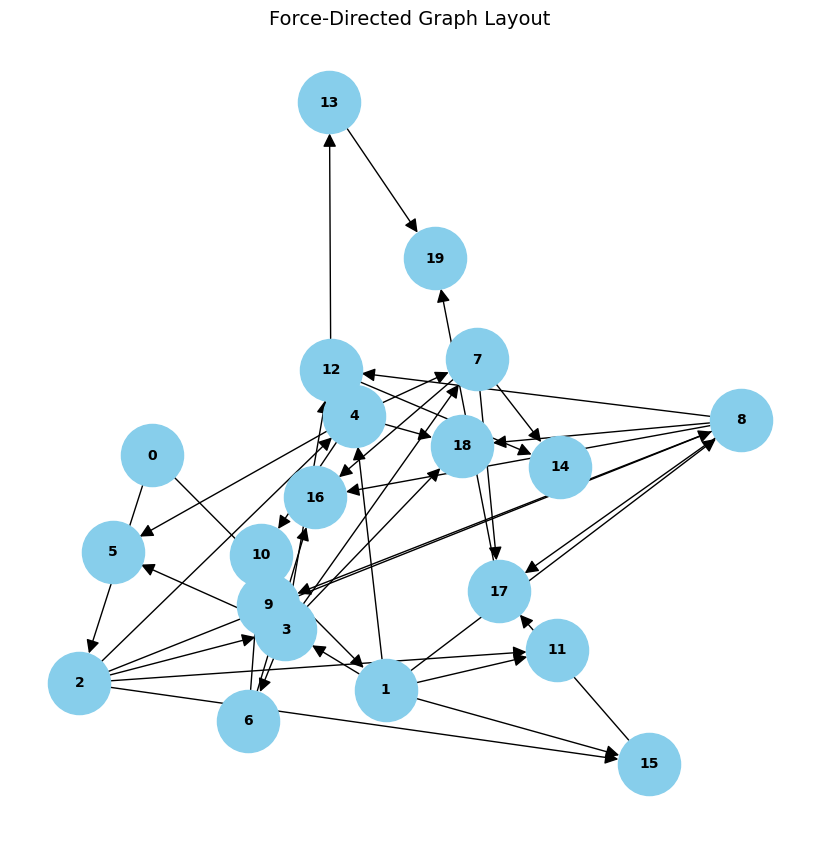

In [5]:
plt.figure(figsize=(8, 8))
nx.draw(graph.getGraph(), layout, with_labels=True, node_color='skyblue', node_size=2000, font_size=10, font_weight='bold', arrowsize=20)
plt.title("Force-Directed Graph Layout", fontsize=14)
plt.axis("off")
plt.show()

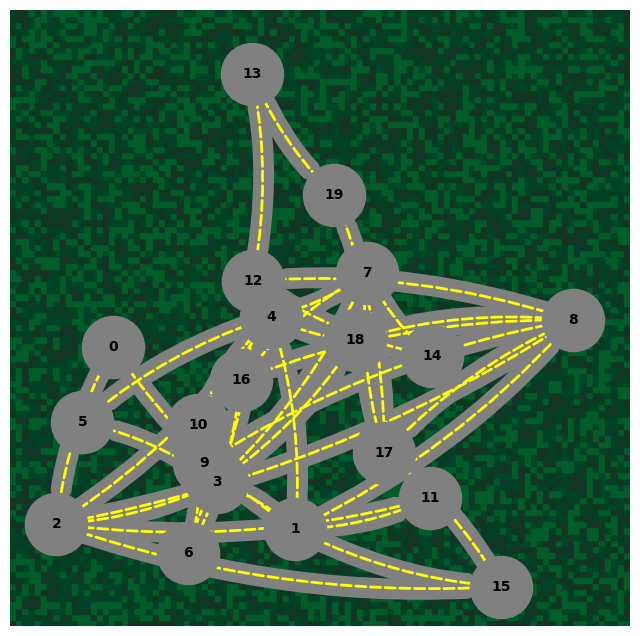

In [6]:
G = graph.getGraph()
custom_layout = layout

x_coords = [pos[0] for pos in custom_layout.values()]
y_coords = [pos[1] for pos in custom_layout.values()]
x_min, x_max = min(x_coords) * 1.2, max(x_coords) * 1.2
y_min, y_max = min(y_coords) * 1.2, max(y_coords) * 1.2

padding = 0.05
x_min, x_max = x_min - padding, x_max + padding
y_min, y_max = y_min - padding, y_max + padding

num_blocks_x = 100
num_blocks_y = 100
block_width = (x_max - x_min) / num_blocks_x
block_height = (y_max - y_min) / num_blocks_y
colors = ['#005C29', '#004225', '#123524']
background = np.random.choice(colors, size=(num_blocks_x, num_blocks_y))

fig, ax = plt.subplots(figsize=(8, 8))

for i in range(num_blocks_x):
    for j in range(num_blocks_y):
        rect = plt.Rectangle(
            (x_min + i * block_width, y_min + j * block_height),
            block_width,
            block_height,
            color=background[i, j]
        )
        ax.add_patch(rect)

nx.draw_networkx_edges(
    G,
    custom_layout,
    ax=ax,
    edge_color='gray',
    width=15,
    arrowsize=0.01,
    connectionstyle="arc3,rad=0.1"
)

nx.draw_networkx_edges(
    G,
    custom_layout,
    ax=ax,
    edge_color='yellow',
    width=2,
    arrowsize=0.01,
    style="dashed",
    connectionstyle="arc3,rad=0.1"
)

nx.draw_networkx_nodes(
    G,
    custom_layout,
    ax=ax,
    node_color='gray',
    node_size=2000
)

nx.draw_networkx_labels(
    G,
    custom_layout,
    ax=ax,
    font_size=10,
    font_weight='bold'
)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.axis('off')

plt.show()


In [7]:
G = graph.getGraph()
custom_layout = layout

x_coords = [pos[0] for pos in custom_layout.values()]
y_coords = [pos[1] for pos in custom_layout.values()]
x_min, x_max = min(x_coords) * 1.2, max(x_coords) * 1.2
y_min, y_max = min(y_coords) * 1.2, max(y_coords) * 1.2

padding = 0.05
x_min, x_max = x_min - padding, x_max + padding
y_min, y_max = y_min - padding, y_max + padding

num_blocks_x = 100
num_blocks_y = 100
block_width = (x_max - x_min) / num_blocks_x
block_height = (y_max - y_min) / num_blocks_y
colors = ['#005C29', '#004225', '#123524']
background = np.random.choice(colors, size=(num_blocks_x, num_blocks_y))

fig, ax = plt.subplots(figsize=(8, 8))

for i in range(num_blocks_x):
    for j in range(num_blocks_y):
        rect = plt.Rectangle(
            (x_min + i * block_width, y_min + j * block_height),
            block_width,
            block_height,
            color=background[i, j]
        )
        ax.add_patch(rect)

nx.draw_networkx_edges(
    G,
    custom_layout,
    ax=ax,
    edge_color='gray',
    width=15,
    arrowsize=0.01,
    connectionstyle="arc3,rad=0.1"
)

nx.draw_networkx_edges(
    G,
    custom_layout,
    ax=ax,
    edge_color='yellow',
    width=1.5,
    arrowsize=0.01,
    style="dashed",
    connectionstyle="arc3,rad=0.1"
)

nx.draw_networkx_nodes(
    G,
    custom_layout,
    ax=ax,
    node_color='gray',
    node_size=2000
)

nx.draw_networkx_labels(
    G,
    custom_layout,
    ax=ax,
    font_size=10,
    font_weight='bold'
)

for node, (x, y) in custom_layout.items():
    img_path = random.choice([
        {'path': 'images/constructions/house.png', 'zoom': 0.11},
        {'path': 'images/constructions/house2.jpg', 'zoom': 0.08},
        {'path': 'images/constructions/house3.jpg', 'zoom': 0.07},
        {'path': 'images/constructions/house4.jpg', 'zoom': 0.07},
    ])
    
    img = mpimg.imread(img_path['path'])
    imagebox = OffsetImage(img, zoom = img_path['zoom'])
    
    ab = AnnotationBbox(
        imagebox, (x, y),
        frameon=False,
        xycoords='data',
        xybox=(0, 0),
        boxcoords="offset points"
    )

    ax.add_artist(ab)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.axis('off')

# Show the plot
plt.show()


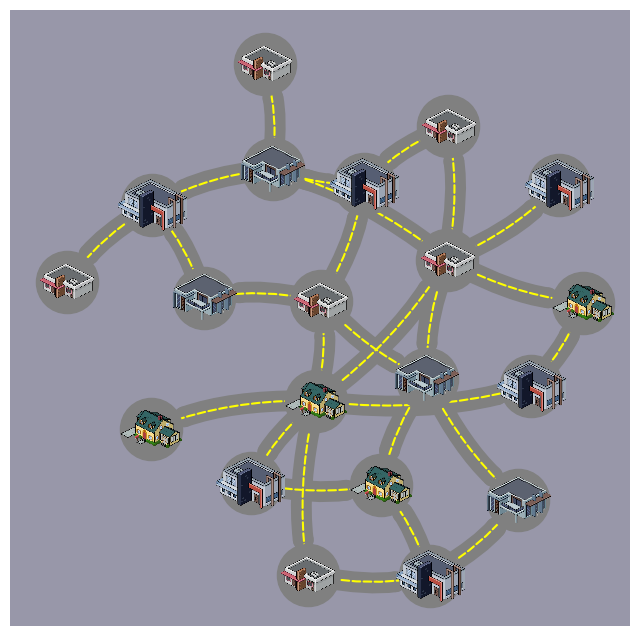

In [8]:
G = graph.getGraph()
custom_layout = layout

x_coords = [pos[0] for pos in custom_layout.values()]
y_coords = [pos[1] for pos in custom_layout.values()]
x_min, x_max = min(x_coords) * 1.2, max(x_coords) * 1.2
y_min, y_max = min(y_coords) * 1.2, max(y_coords) * 1.2

padding = 0.05
x_min, x_max = x_min - padding, x_max + padding
y_min, y_max = y_min - padding, y_max + padding

num_blocks_x = 100
num_blocks_y = 100
block_width = (x_max - x_min) / num_blocks_x
block_height = (y_max - y_min) / num_blocks_y
colors = ['#9897A9']
background = np.random.choice(colors, size=(num_blocks_x, num_blocks_y))

fig, ax = plt.subplots(figsize=(8, 8))

for i in range(num_blocks_x):
    for j in range(num_blocks_y):
        rect = plt.Rectangle(
            (x_min + i * block_width, y_min + j * block_height),
            block_width,
            block_height,
            color=background[i, j]
        )
        ax.add_patch(rect)

nx.draw_networkx_edges(
    G,
    custom_layout,
    ax=ax,
    edge_color='gray',
    width=15,
    arrowsize=0.01,
    connectionstyle="arc3,rad=0.1"
)

nx.draw_networkx_edges(
    G,
    custom_layout,
    ax=ax,
    edge_color='yellow',
    width=1.5,
    arrowsize=0.01,
    style="dashed",
    connectionstyle="arc3,rad=0.1"
)

nx.draw_networkx_nodes(
    G,
    custom_layout,
    ax=ax,
    node_color='gray',
    node_size=2000
)

nx.draw_networkx_labels(
    G,
    custom_layout,
    ax=ax,
    font_size=10,
    font_weight='bold'
)

for node, (x, y) in custom_layout.items():
    img_path = random.choice([
        {'path': 'images/constructions/house.png', 'zoom': 0.11},
        {'path': 'images/constructions/house2.jpg', 'zoom': 0.08},
        {'path': 'images/constructions/house3.jpg', 'zoom': 0.065},
        {'path': 'images/constructions/house4.jpg', 'zoom': 0.09},
    ])
    
    img = mpimg.imread(img_path['path'])
    imagebox = OffsetImage(img, zoom = img_path['zoom'])
    
    ab = AnnotationBbox(
        imagebox, (x, y),
        frameon=False,
        xycoords='data',
        xybox=(0, 0),
        boxcoords="offset points"
    )

    ax.add_artist(ab)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.axis('off')

# Show the plot
plt.savefig('third_plot.png', dpi=300, bbox_inches='tight')
plt.show()

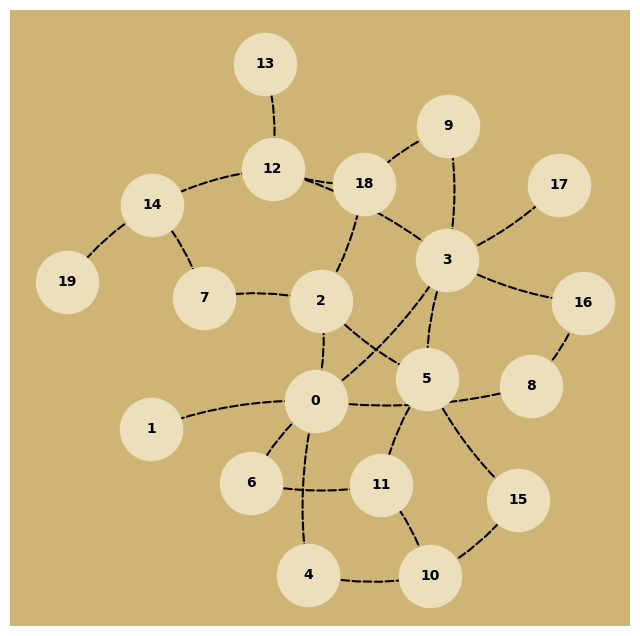

In [9]:
G = graph.getGraph()
custom_layout = layout

x_coords = [pos[0] for pos in custom_layout.values()]
y_coords = [pos[1] for pos in custom_layout.values()]
x_min, x_max = min(x_coords) * 1.2, max(x_coords) * 1.2
y_min, y_max = min(y_coords) * 1.2, max(y_coords) * 1.2

padding = 0.05
x_min, x_max = x_min - padding, x_max + padding
y_min, y_max = y_min - padding, y_max + padding

num_blocks_x = 100
num_blocks_y = 100
block_width = (x_max - x_min) / num_blocks_x
block_height = (y_max - y_min) / num_blocks_y
colors = ['#ceb575']
background = np.random.choice(colors, size=(num_blocks_x, num_blocks_y))

fig, ax = plt.subplots(figsize=(8, 8))

for i in range(num_blocks_x):
    for j in range(num_blocks_y):
        rect = plt.Rectangle(
            (x_min + i * block_width, y_min + j * block_height),
            block_width,
            block_height,
            color=background[i, j]
        )
        ax.add_patch(rect)

nx.draw_networkx_edges(
    G,
    custom_layout,
    ax=ax,
    edge_color='black',
    width=1.5,
    arrowsize=0.01,
    style="dashed",
    connectionstyle="arc3,rad=0.1"
)

nx.draw_networkx_nodes(
    G,
    custom_layout,
    ax=ax,
    node_color='#ebdfbc',
    node_size=2000
)

nx.draw_networkx_labels(
    G,
    custom_layout,
    ax=ax,
    font_size=10,
    font_weight='bold'
)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.axis('off')

plt.savefig('third_plot.png', dpi=300, bbox_inches='tight')
plt.show()

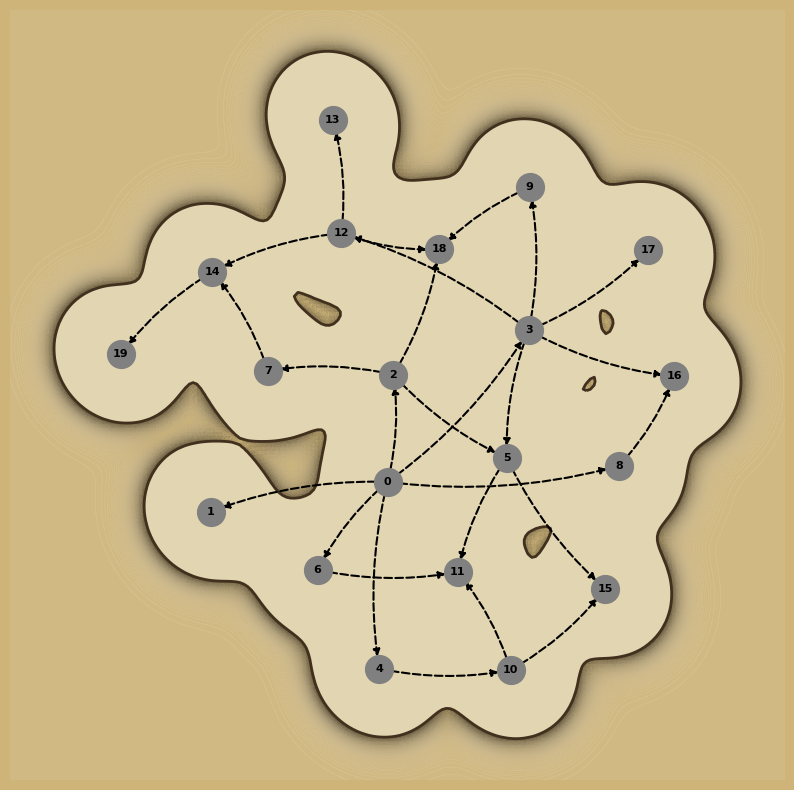

In [10]:
margin_factor = 0.2

node_positions = np.array([pos for pos in custom_layout.values()])
x_coords = node_positions[:, 0]
y_coords = node_positions[:, 1]

x_range = x_coords.max() - x_coords.min()
y_range = y_coords.max() - y_coords.min()

x_min = x_coords.min() - margin_factor * x_range
x_max = x_coords.max() + margin_factor * x_range
y_min = y_coords.min() - margin_factor * y_range
y_max = y_coords.max() + margin_factor * y_range

x_grid, y_grid = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200)
)

kde = gaussian_kde(node_positions.T, bw_method=0.2) 
density = kde(np.vstack([x_grid.ravel(), y_grid.ravel()])).reshape(x_grid.shape)

fig, ax = plt.subplots(figsize=(10, 10))
fig.patch.set_facecolor('#ceb479')

contour_levels = np.linspace(density.min(), density.max(), 11)

ax.contourf(
    x_grid,
    y_grid,
    density,
    levels=[contour_levels[1], contour_levels[10]],
    colors=["#e2d5b1"], 
)

contour = ax.contour(
    x_grid,
    y_grid,
    density,
    levels=[contour_levels[1]],
    colors="#41301e",
    linewidths=2
)

blur = ax.contourf(
    x_grid,
    y_grid,
    density,
    levels=np.linspace(contour_levels[0], contour_levels[1], 100),
    cmap="binary",
    alpha=0.08
)

edges = nx.draw_networkx_edges(
    G,
    custom_layout,
    ax=ax,
    edge_color='black',
    width=1.5,
    style="dashed",
    connectionstyle="arc3,rad=0.1"
)
for edge in edges:
    edge.set_zorder(4)

nodes = nx.draw_networkx_nodes(
    G,
    custom_layout,
    ax=ax,
    node_color='gray',
    node_size=400
)
nodes.set_zorder(5)

labels = nx.draw_networkx_labels(
    G,
    custom_layout,
    ax=ax,
    font_size=8,
    font_weight='bold',
    font_color="black"
)
for label in labels.values():
    label.set_zorder(6)

ax.set_xlim(x_coords.min() - margin_factor * x_range, x_coords.max() + margin_factor * x_range)
ax.set_ylim(y_coords.min() - margin_factor * y_range, y_coords.max() + margin_factor * y_range)

ax.axis('off')

plt.show()


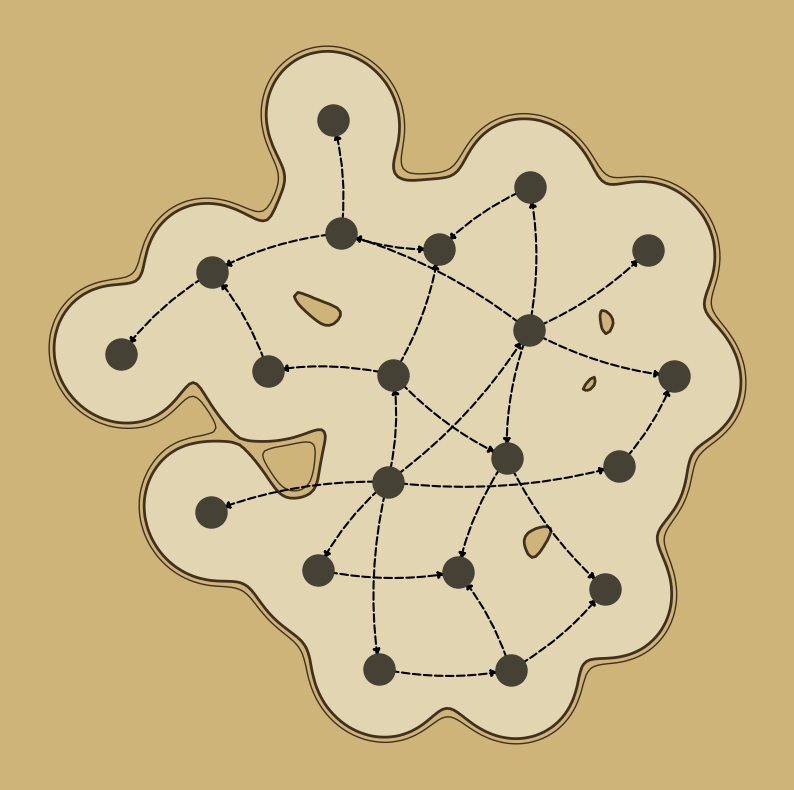

In [11]:
margin_factor = 0.2

node_positions = np.array([pos for pos in custom_layout.values()])
x_coords = node_positions[:, 0]
y_coords = node_positions[:, 1]

x_range = x_coords.max() - x_coords.min()
y_range = y_coords.max() - y_coords.min()

x_min = x_coords.min() - margin_factor * x_range
x_max = x_coords.max() + margin_factor * x_range
y_min = y_coords.min() - margin_factor * y_range
y_max = y_coords.max() + margin_factor * y_range

x_grid, y_grid = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200)
)

kde = gaussian_kde(node_positions.T, bw_method=0.2) 
density = kde(np.vstack([x_grid.ravel(), y_grid.ravel()])).reshape(x_grid.shape)

fig, ax = plt.subplots(figsize=(10, 10))
fig.patch.set_facecolor('#ceb479')

contour_levels = np.linspace(density.min(), density.max(), 11)

# Island fill
ax.contourf(
    x_grid,
    y_grid,
    density,
    levels=[contour_levels[1], contour_levels[10]],
    colors=["#e2d5b1"], 
)

ax.contour(
    x_grid,
    y_grid,
    density,
    levels=[contour_levels[1]],
    colors="#41301e",
    linewidths=2
)

ax.contour(
    x_grid,
    y_grid,
    density,
    levels=[contour_levels[1] * 0.7],
    colors="#41301e",
    linewidths=1
)

edges = nx.draw_networkx_edges(
    G,
    custom_layout,
    ax=ax,
    edge_color='black',
    width=1.5,
    style="dashed",
    connectionstyle="arc3,rad=0.1"
)
for edge in edges:
    edge.set_zorder(4)

nodes = nx.draw_networkx_nodes(
    G,
    custom_layout,
    ax=ax,
    node_color='#464135',
    node_size=500
)
nodes.set_zorder(5)

for label in labels.values():
    label.set_zorder(6)

ax.set_xlim(x_coords.min() - margin_factor * x_range, x_coords.max() + margin_factor * x_range)
ax.set_ylim(y_coords.min() - margin_factor * y_range, y_coords.max() + margin_factor * y_range)

ax.axis('off')

plt.show()


In [12]:
def remove_white_pixels(image_path, tolerance=20):
    """
    Remove white pixels (and near-white pixels) from an image and make them transparent.
    The tolerance parameter defines how close a pixel must be to white to be considered white.
    Returns an image with transparency where white or near-white pixels were.
    """
    img = Image.open(image_path).convert('RGBA')  # Open image and convert to RGBA (with alpha channel)
    data = np.array(img)

    # Ensure the image has 4 channels (RGBA)
    if data.shape[2] != 4:
        raise ValueError("Image does not have 4 channels (RGBA).")

    # Find pixels close to white (within a tolerance)
    # A pixel is considered "close to white" if all RGB components are within the range [255-tolerance, 255]
    white_pixels = np.all(
        (data[:, :, :3] >= (255 - tolerance)) & (data[:, :, :3] <= 255), 
        axis=-1
    )

    # Set these pixels to transparent (alpha = 0)
    data[white_pixels, 3] = 0  # Set the alpha channel (transparency) for close-to-white pixels

    # Create and return the modified image
    return Image.fromarray(data)

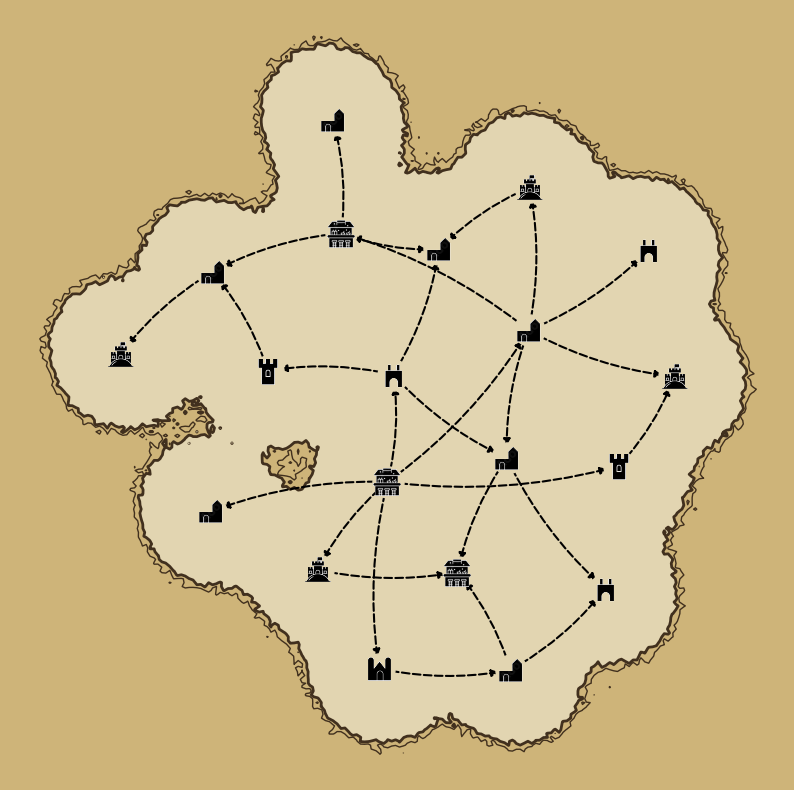

In [13]:
margin_factor = 0.2

node_positions = np.array([pos for pos in custom_layout.values()])
x_coords = node_positions[:, 0]
y_coords = node_positions[:, 1]

x_range = x_coords.max() - x_coords.min()
y_range = y_coords.max() - y_coords.min()

x_min = x_coords.min() - margin_factor * x_range
x_max = x_coords.max() + margin_factor * x_range
y_min = y_coords.min() - margin_factor * y_range
y_max = y_coords.max() + margin_factor * y_range

x_grid, y_grid = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200)
)

kde = gaussian_kde(node_positions.T, bw_method=0.215) 
density = kde(np.vstack([x_grid.ravel(), y_grid.ravel()])).reshape(x_grid.shape)

# Generate a spatial weight map for noise
weight_map = np.random.uniform(0.5, 1.5, size=density.shape)  # Random spatial weights
weight_map = gaussian_filter(weight_map, sigma=5)  # Smooth weight map to avoid sharp transitions

# Add noise with varying intensity
noise_strength = 0.05
noise = np.random.normal(scale=noise_strength * density.std(), size=density.shape)
weighted_noise = noise * weight_map

density_with_noise = density + weighted_noise

# Ensure density_with_noise remains non-negative
density_with_noise = np.clip(density_with_noise, 0, None)

# Smooth the noisy density
density_with_noise = gaussian_filter(density_with_noise, sigma=0.1)

# Recompute contour levels
contour_levels = np.linspace(density_with_noise.min(), density_with_noise.max(), 11)

fig, ax = plt.subplots(figsize=(10, 10))
fig.patch.set_facecolor('#ceb479')

# Island fill
ax.contourf(
    x_grid,
    y_grid,
    density_with_noise,
    levels=[contour_levels[1], contour_levels[10]],
    colors=["#e2d5b1"], 
)

# Primary imperfect contour line
ax.contour(
    x_grid,
    y_grid,
    density_with_noise,
    levels=[contour_levels[1]],
    colors="#41301e",
    linewidths=2
)

# Secondary imperfect contour line
ax.contour(
    x_grid,
    y_grid,
    density_with_noise,
    levels=[contour_levels[1] * 0.7],
    colors="#41301e",
    linewidths=1
)

edges = nx.draw_networkx_edges(
    G,
    custom_layout,
    ax=ax,
    edge_color='black',
    width=1.5,
    style="dashed",
    connectionstyle="arc3,rad=0.1"
)
for edge in edges:
    edge.set_zorder(4)

nodes = nx.draw_networkx_nodes(
    G,
    custom_layout,
    ax=ax,
    node_color='#e2d5b1',
    node_size=500
)
nodes.set_zorder(5)

for node, (x, y) in custom_layout.items():
    img_path = random.choice([
        {'path': 'images/constructions/treasure_map/house1.png', 'zoom': 0.13},
        {'path': 'images/constructions/treasure_map/house2.png', 'zoom': 0.13},
        {'path': 'images/constructions/treasure_map/house3.png', 'zoom': 0.13},
        {'path': 'images/constructions/treasure_map/house4.png', 'zoom': 0.16},
        {'path': 'images/constructions/treasure_map/house5.png', 'zoom': 0.13},
        {'path': 'images/constructions/treasure_map/house6.png', 'zoom': 0.13},
    ])
    
    processed_img = remove_white_pixels(img_path['path'])
    imagebox = OffsetImage(processed_img, zoom = img_path['zoom'])

    ab = AnnotationBbox(
        imagebox, (x, y),
        frameon=False,
        xycoords='data',
        xybox=(0, 0),
        boxcoords="offset points"
    )
    ab.set_zorder(6)
    
    ax.add_artist(ab)

for label in labels.values():
    label.set_zorder(6)

ax.set_xlim(x_coords.min() - margin_factor * x_range, x_coords.max() + margin_factor * x_range)
ax.set_ylim(y_coords.min() - margin_factor * y_range, y_coords.max() + margin_factor * y_range)

ax.axis('off')

plt.show()

In [74]:
props = [
        {'path': 'images/treasure_map/sea_props/prop_1.png', 'zoom': 0.1, 'size': 1},
        {'path': 'images/treasure_map/sea_props/prop_2.png', 'zoom': 0.06, 'size': 1},
        {'path': 'images/treasure_map/sea_props/prop_3.png', 'zoom': 0.1, 'size': 1},
        {'path': 'images/treasure_map/sea_props/prop_4.png', 'zoom': 0.06, 'size': 1},
    ]